<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model
Loosely based on the following article and adapted to binary classification:
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

# Import Packages & Data

In [ ]:
import pandas as pd
import numpy as np

# preprocessing
import re
import nltk 
from nltk.corpus import stopwords 
nltk.download('stopwords')

# model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras

# plotting
import matplotlib.pyplot as plt

# accuracies
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [ ]:
# remove retold category
df = df[df.memType != 'retold']

#Text preprocessing

In [ ]:
# function to test whether preprocessing worked
def print_plot(index):
    example = df[df.index == index][['story', 'memType']].values[0]
    if len(example) > 0:
        print(example[0])
        print('memType:', example[1])
print_plot(10)

About a month ago me and my girlfriend went to the zoo. It was an unexpected trip we just decided to go on a random Wednesday. It was a pretty hot day that day considering it was the middle of July. As soon as we got in, we saw that there were some seals to the left of the entrance so we saw them for a few minutes. Then we went to the insect section of the zoo. There were so many of them like spiders, scorpions, also bigger animals like cobras, rattlesnakes stuff like that. Then we saw the elephants. It was pretty interesting because they were in an area that looked like a jungle and off in the distance we heard gorillas grunting. So we walked around until we found the gorillas and around there we also saw other kinds of primates like chimpanzees. We walked around a bit more and we stumbled upon all the other African animals like tigers, lions, giraffes etc. It was actually pretty cool to see the giraffes because one of them got really close to me. Along the way we saw a lot of differe

In [ ]:
# function to clean text
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

# apply function to stories
df['story'] = df['story'].apply(clean_text)
df['story'] = df['story'].str.replace('\d+', '')


In [ ]:
# Print one story to check if it worked
print_plot(10)

vacation visit southeast asia every years least small tourist town thailand right pattaya beach fairly late one evening decided roam around city take pictures citizens shops nightclubs etc found rather secluded dingy part city wasnt sure eactly get back hotel looking one motorbike tais didnt see looking around group thais probably early s could tell part gang something like thought sure going get robbed beat across small street giving eye sudden tai went waved frantically saw drove pick got back hotel safely pretty shaken knew things going go badly small gang caught city another two weeks still ventured tried lot careful parts ventured really known better quite countries cities safe even though im somewhat used types environments still scary tourists known disappear never show happens fairly often especially countries completely corrupt police force still travel im little careful city go go particular city
memType: imagined


In [ ]:
# tokenize data
MAX_NB_WORDS = 50000 # max number of tokens in vocabulary
MAX_SEQUENCE_LENGTH = 750 # max number of words in each story
EMBEDDING_DIM = 100 # dimensions of embedding layer 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['story'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24496 unique tokens.


In [ ]:
# create variable with tokenized stories, padded to same length
X = tokenizer.texts_to_sequences(df['story'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5535, 750)


In [ ]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes
label = df['label'].values

# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']


In [ ]:
# create dummy variable for categories
Y = pd.get_dummies(df['memType']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5535, 2)


# Split data

In [ ]:
# split data into training and testing using 80/20 split
X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X,Y, label, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4428, 750) (4428, 2)
(1107, 750) (1107, 2)


# Building Model

In [ ]:
# use Sequential model
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))

# add stacked LSTM layers using the Sigmoid activation function
# return_sequences is true in order to use output layer as input for next layer
model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#model.add(keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences= True))
#model.add(keras.layers.LSTM(25, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='sigmoid'))

# compile the model using binary cross entropy loss function and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 2 # set number of epochs
batch_size = 32 # set batch size

# fit model and output accuracy
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
111/111 [==============================] - 366s 3s/step - loss: 0.6926 - accuracy: 0.5219 - val_loss: 0.6902 - val_accuracy: 0.5711
Epoch 2/3
111/111 [==============================] - 358s 3s/step - loss: 0.6477 - accuracy: 0.6661 - val_loss: 0.6594 - val_accuracy: 0.6253
Epoch 3/3
111/111 [==============================] - 358s 3s/step - loss: 0.4746 - accuracy: 0.7908 - val_loss: 0.6784 - val_accuracy: 0.6185


# Model Evaluation

In [ ]:
 # evaluation on test data
 accr = model.evaluate(X_test,Y_test) 
 print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 12s 348ms/step - loss: 0.6824 - accuracy: 0.5953
Test set
 Loss: 0.682
 Accuracy: 0.595


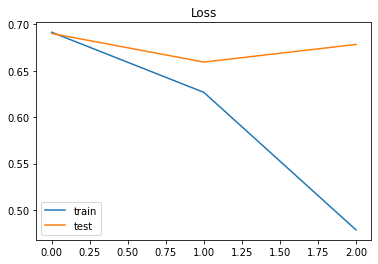

In [ ]:
# plot train and test losses across epochs
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

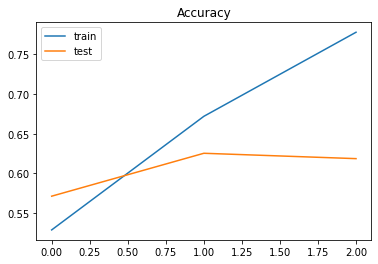

In [ ]:
# plot train and test accuracies across epochs
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# predict categories on test data
Y_pred = model.predict_classes(X_test)
Y_pred = pd.get_dummies(Y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# compute overall accuracy, precision, recall, f1 scores
print('Accuracy: ', accuracy_score(Y_test, Y_pred))
print('Precision: ', precision_score(Y_test, Y_pred, average='weighted', zero_division=1)) # weighted = same as macroaveraging but with auto weights
print('Recall: ', recall_score(Y_test, Y_pred, average='weighted', zero_division=1))
print('F1:', f1_score(Y_test, Y_pred, average='weighted'))

Accuracy:  0.5953026196928636
Precision:  0.6006363703182089
Recall:  0.5953026196928636
F1: 0.5804880887248254


In [ ]:
# create confusion matrix of true and predicted labels
confusion_matrix(label_test, model.predict_classes(X_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[446, 132],
       [316, 213]])

In [ ]:
# compute precision, recall, fscore, support scores by category
precision, recall, fscore, support = score(Y_test, Y_pred)

# show accuracies for each category in dataframe
df_acc = pd.DataFrame()
df_acc['precision']=pd.Series(precision)
df_acc['recall']=pd.Series(recall)
df_acc['fscore']=pd.Series(fscore)
df_acc['support']=pd.Series(support)
print(df_acc)

   precision    recall    fscore  support
0   0.585302  0.771626  0.665672      578
1   0.617391  0.402647  0.487414      529


In [ ]:
# Compute Matthews correlation coefficient
matthews_corrcoef(label_test, model.predict_classes(X_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.18794653871350372